In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.morphology import skeletonize
from skimage import measure
import matplotlib.pyplot as plt

# define seeds
np.random.seed(42)
torch.manual_seed(42)

## Step 1: Data Acquisition
### Here, I divide this step into two main tasks:
1. Explore DICOM images and their Metadata (Real CT images)
2. Generate synthetic data

#### Task 2: Synthetic CT series at two noise levels
The key idea is to define an image quality metric and see directionally if the approach is correct

In [23]:
# [h, w, n_slices]
input_shape = (128, 128, 30)

def generate_synthetic_vessel(noise_level=0.0, input_shape=(128, 128, 30)):
    volume = torch.zeros(input_shape)
    
    # define base
    center_base = torch.tensor([64, 64])
    radius = 10
    
    # use meshgrid for 'ij' indexing so that Y corresponds to rows and X corresponds to columns
    Y, X = torch.meshgrid(torch.arange(input_shape[0]),
                           torch.arange(input_shape[1]), indexing='ij')
    
    for z in range(input_shape[2]):
        shift_row = int(5 * np.sin(z / 3.0))
        shift_col = int(5 * np.cos(z / 3.0))
        shift = torch.tensor([shift_row, shift_col])
        
        center = center_base + shift
        
        # compute squared distance from each pixel to the center.
        dist2 = (Y - center[0])**2 + (X - center[1])**2
        
        # create a binary mask for the disk
        mask = dist2 <= radius**2
        
        volume[:, :, z] = mask.float()
    
    # add Guassian noise
    if noise_level > 0:
        noise = torch.normal(0, noise_level, size=input_shape)
        volume = volume + noise
        volume = torch.clamp(volume, 0, 1)
        
    return volume

phase1 = generate_synthetic_vessel(noise_level=0.05, input_shape=input_shape)
phase2 = generate_synthetic_vessel(noise_level=0.15, input_shape=input_shape)


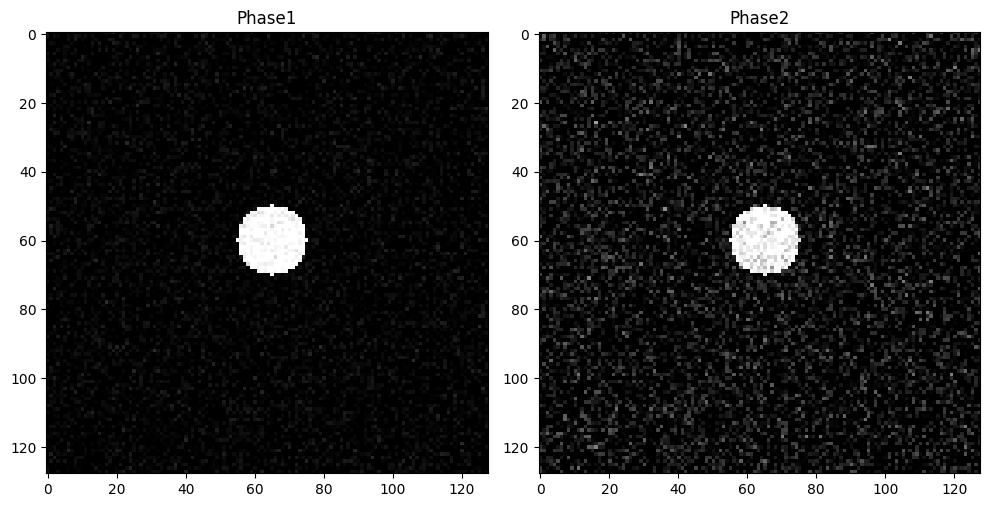

In [28]:
phase1.shape, phase2.shape
slice_idx = phase1.shape[2] // 2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(phase1.numpy()[:, :, slice_idx], cmap='gray')
axes[0].set_title("Phase1")

axes[1].imshow(phase2.numpy()[:, :, slice_idx], cmap='gray')
axes[1].set_title("Phase2")

plt.tight_layout()
plt.show()

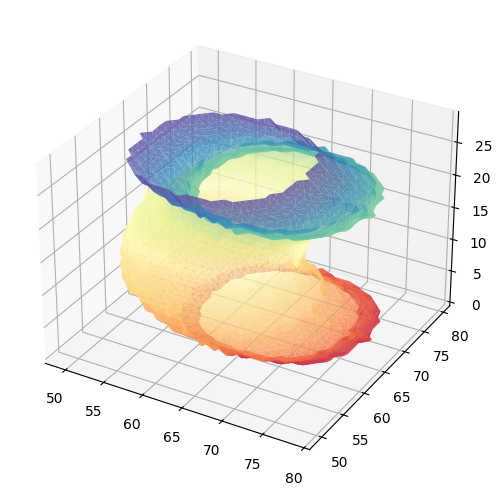

In [33]:

v, f, n, val = measure.marching_cubes(phase1.numpy(), level=0.5)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(v[:, 0], v[:, 1], f, v[:, 2],
                cmap='Spectral', lw=1, alpha=0.8)
plt.tight_layout()
plt.show()


In [34]:
class DummyIQNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        quality_score = self.fc(x)
        return quality_score

iq_model = DummyIQNet()